In [4]:
## STANDARD PYTHON LIBS
import os
import re
import sys
import cv2
import PIL
import math
import time
import random
import scipy.misc
import skimage.io
import skimage.transform
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ADDING TO ROOT
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(ROOT_DIR)

## CUSTOM LIBS
import src.utils as utils
import src.model as modellib
from src.config import Config
import src.visualize as visualize

# GPU LIBS
import keras
import tensorflow as tf

print ('TF : ', tf.__version__, '  Keras : ', keras.__version__)

# if utils.check_gpu(verbose=0):
#     pass
# else:
#     sys.exit(1)

TF :  1.6.0   Keras :  2.1.5


Using TensorFlow backend.


In [19]:
if 'src.mapillary' in sys.modules : del sys.modules['src.mapillary']
if 'src.utils'     in sys.modules : del sys.modules['src.utils']
if 'src.model'     in sys.modules : del sys.modules['src.model']

import src.utils as utils
import src.model as modellib
import src.mapillary as mapillary

if __name__ == "__main__":
    url_dataset = '/home/play/datasets/open_datasets/mapillary'
    mapillary_mapper = '/home/play/playment/Mask_RCNN/demo/raw/merge__cityscapes_mapillary_v2.json'
    mapillary_config = mapillary.MapillaryConfig()
    trainData = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'train')
    valData   = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'val')

Mode : train has 17979 images
Mode : val has 2000 images


 - Instance URL : /home/play/datasets/open_datasets/mapillary/mapillary-vistas-dataset_public_v1.0/training/instances/wOoqsMa2vihaDrShw1wOLg.png
 - Total Masks :  6
 - Playment Classes :  {24: 4, 9: 1, 21: 1}
 - Total Printed Masks :  18


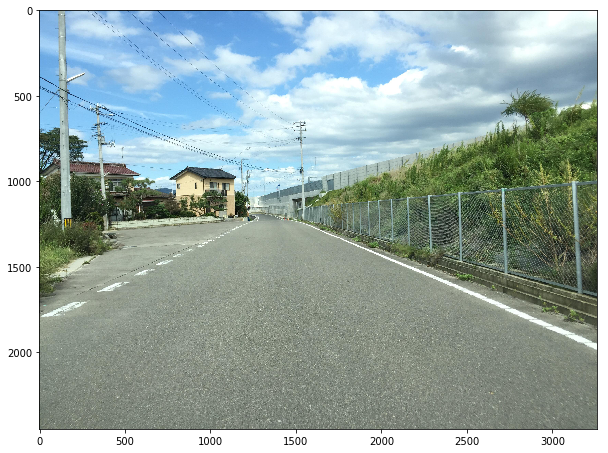

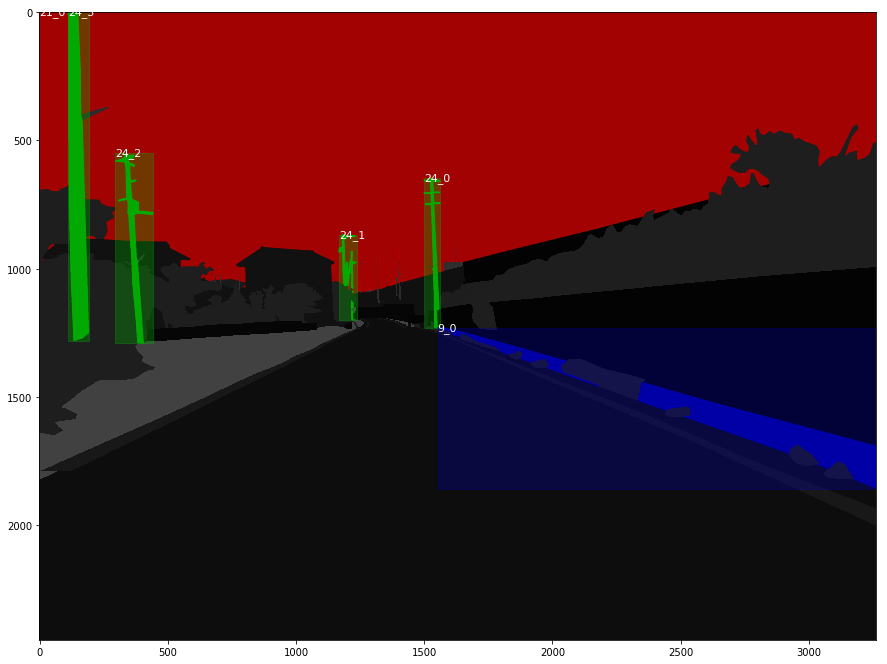

In [18]:
# idx, show, verbose, test = 2459, True, True, True
# idx, show, verbose, test = 12488, True, True, True
idx, show, verbose, test = 0, True, True, False
img = trainData.load_image(idx, show=show)
masks, class_ids = trainData.load_mask(idx, show=show, verbose=verbose, test=test)

In [20]:
train_generator = modellib.data_generator(trainData, mapillary_config, shuffle=True, batch_size=mapillary_config.BATCH_SIZE)
val_generator   = modellib.data_generator(valData, mapillary_config, shuffle=True, batch_size=mapillary_config.BATCH_SIZE,augment=False)
input_, output_ =  next(train_generator)
print (input_.shape, output_)

Time Taken for one batch :  4.76


AttributeError: 'list' object has no attribute 'shape'

In [4]:
# idx, show = 1200, True
# img = valData.load_image(idx, show=show)
# masks, class_ids = valData.load_mask(idx, show=show, verbose=True)

## TRAINING

In [6]:
if 'src.model' in sys.modules : del sys.modules['src.model']
if 'src.utils'     in sys.modules : del sys.modules['src.utils']
import src.utils as utils
import src.model as modellib

    
MODEL_DIR = os.path.join(ROOT_DIR, 'demo', 'model', 'logs')
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'demo', 'model', "mask_rcnn_coco.h5")
model = modellib.MaskRCNN(mode="training", config=mapillary_config, model_dir=MODEL_DIR)

# init_with = "coco"  # imagenet, coco, or last
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model_path = model.find_last()[1]
    print (' - Path : ', model_path)
    model.load_weights(model_path, by_name=True)

 - Path :  /home/play/playment/production/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_0002.h5


In [ ]:
model.train(trainData, valData, 
            learning_rate=mapillary_config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 3. LR=0.001

Checkpoint Path: /home/play/playment/production/Mask_RCNN/demo/model/logs/mapillary20180315T0317/mask_rcnn_mapillary_{epoch:04d}.h5
Selecting layers to train
In model:  rpn_model
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Total params: 63,803,372
Trainable params: 21,139,052
Non-trainable params: 42,664,320

Compiled ! 



/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 4/5
2250/2250 [==============================] - 48911s 22s/step - loss: 2.1087 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 1.0236 - mrcnn_class_loss: 0.3710 - mrcnn_bbox_loss: 0.3334 - mrcnn_mask_loss: 0.2937 - val_loss: 2.0958 - val_rpn_class_loss: 0.0746 - val_rpn_bbox_loss: 0.8738 - val_mrcnn_class_loss: 0.5132 - val_mrcnn_bbox_loss: 0.2930 - val_mrcnn_mask_loss: 0.3412
Epoch 5/5
 686/2250 [========>.....................] - ETA: 9:28:56 - loss: 1.9547 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 0.9743 - mrcnn_class_loss: 0.3288 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.2691

In [ ]:
sys.exit(1)

# INFERENCE

In [ ]:
if 'src.model' in sys.modules : del sys.modules['src.model']
import src.model as modellib
class InferenceConfig(mapillary.MapillaryConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
print (' - Batch Size : ', inference_config.BATCH_SIZE)
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)
model_path = model.find_last()[1]
print (' - Model Path : ', model_path)

if model_path != None:
    model.load_weights(model_path, by_name=True)
else:
    sys.exit(1)

In [ ]:
if 'src.mapillary' in sys.modules : del sys.modules['src.mapillary']
import src.mapillary as mapillary
testData = mapillary.MapillaryDataset(url_dataset, mapillary_mapper, mapillary_config, data_type = 'test')

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

test_img = testData.load_image(45)
results  = model.detect([test_img], verbose=1)
r = results[0]

if 'src.visualize' in sys.modules : del sys.modules['src.visualize']
import src.visualize as visualize
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                            valData.class_names, r['scores'], ax=get_ax())

# SCRATCHPAD